### Imports

In [9]:
import json
import time
import requests
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

### Constants

In [2]:
SUBREDDIT = 'roastme'

### Utilties

In [3]:
def gen_pushshift_submission_url(subreddit, timestamp):
    return 'https://api.pushshift.io/reddit/submission/search/?subreddit={}&size=500&before={}'.format(subreddit, timestamp)

def gen_pushshift_comments_url(post_id, timestamp):
    return 'https://api.pushshift.io/reddit/comment/search/?link_id={}&limit=500&before={}'.format(post_id, timestamp)

def try_and_repeat(url, n=20, sleep=30, verbose=True):
    for i in range(n):
        response = requests.get(url)
        if response.status_code == 200: break
        if verbose: print('Failed {}, trying again...'.format(response.status_code))
        time.sleep(sleep)
        
    return response

def get_submissions(subreddit, n=1000, min_comments=10, min_age=7, verbose=2):
    all_data = []
    previous_epoch = int((datetime.utcnow() - timedelta(days=min_age)).timestamp())
    
    while len(all_data) < n:
        pushshift_endpoint = gen_pushshift_submission_url(subreddit, previous_epoch)
        if verbose > 1: print('requesting {}...'.format(pushshift_endpoint))
        response = try_and_repeat(pushshift_endpoint, verbose=verbose>1).json()
        
        if 'data' in response and len(response['data']) > 0:           
            data = response['data']
            data = filter_submission(data, min_comments=min_comments)
            all_data.extend(data)
            previous_epoch = data[-1]['created_utc']
        else:
            if verbose > 0: print('No more posts before {}'.format(previous_epoch))
            break
        
    if verbose > 1: print('Retrieved posts: {}'.format(len(all_data)))
        
    return all_data

def filter_submissions(submissions, min_comments=10, min_karma=0, exclude_meta):
    filtered = [
        submission 
        for submission in submissions:
        if not (submission['num_comments'] < 10 or 
        submission['score'] < min_karma or 
        (submission['is_meta'] and exclude_meta) or 
        submission['is_video'] or 
        submission['is_self'])
    ]
            
    return filtered

def get_comments(post_id, verbose=True):
    comment_data = []
    previous_epoch = int(datetime.utcnow().timestamp())

    while True:
        pushshift_endpoint = gen_pushshift_comments_url(post_id, previous_epoch)
        if verbose: print('requesting {}...'.format(pushshift_endpoint))
        response = try_and_repeat(pushshift_endpoint)
        response = requests.get(pushshift_endpoint).json()

        if 'data' in response and len(response['data']) > 0:
            data = response['data']
            comment_data.extend(data)
            previous_epoch = data[-1]['created_utc']
        else:
            break

    if verbose: print('Retrieved comments: {}'.format(len(comment_data)))
        
    return comment_data

def get_comments_from_submissions(submissions, verbose=2):
    for i, submission in enumerate(submissions):
        if verbose >1: print('{}/{}'.format(i+1, len(submissions)))
        post_id = submission['permalink'].split('/')[4]
        print(post_id)
        comments = get_comments(post_id, verbose=verbose)
        submission['comments'] = comments
        print()
        
    return submissions

### Get Posts

In [4]:
submissions = get_submissions(SUBREDDIT, n=100)

requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=500&before=1612916742...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=500&before=1612740715...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=500&before=1612388185...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=500&before=1612264146...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=500&before=1612149109...
Retrieved posts: 123


### Get Comments

In [5]:
submissions = get_comments_from_submissions(submissions)

1/123
lg5qtr
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lg5qtr&limit=500&before=1613521555...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lg5qtr&limit=500&before=1612894225...
Retrieved comments: 76

2/123
lg49li
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lg49li&limit=500&before=1613521562...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lg49li&limit=500&before=1612881233...
Retrieved comments: 109

3/123
lg23e9
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lg23e9&limit=500&before=1613521570...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lg23e9&limit=500&before=1612896633...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lg23e9&limit=500&before=1612873602...
Retrieved comments: 822

4/123
lfys1x
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lfys1x&limit=500&before=1613521582...
requesting https://api.pushshift.i

### Save Data

In [10]:
with open('../data/raw_submissions_data_100.json', 'w') as j:
    json.dump(submissions, j)

### Analysis

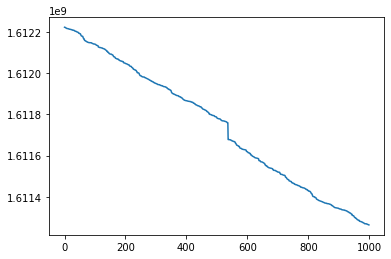

In [9]:
plt.plot([s['created_utc'] for s in submissions])

In [ ]:
plt.hist([s['score'] for s in submission_data])

In [18]:
sum([d['is_meta'] for d in all_data])

0

In [19]:
sum([d['is_video'] for d in all_data])

2

In [20]:
sum([d['is_self'] for d in all_data])

0